# Finding genes in a gene module

Suppose I know a few genes that are involved in a particular process in a particular cell line. I would like to find candidates for other genes that might be involved, either in participating in the same process or in regulating the process. How can I do this?

One approach is to look for genes that are co-expressed with the known genes. If a gene is co-expressed with a set of genes that are known to be involved in a particular process, then it is likely that the gene is also involved in the same process. 

However, what makes this difficult is pleiotropy. A gene can be involved in multiple biological processes. Yet co-expression data is based on pairwise associations. So, even if gene A is associated with gene B and gene C, and gene A particpates in process 1, it is not necessarily the case that gene B and gene C participate in process 1. (This is because gene A may also be associated with process 2 and 3.)

In principle you could look to higher-order interactions to solve this. But this is statistically infeasible.

Here, we look to gene embeddings learned in a neural network trained on gene expression prediction. 

## The language analogy

Just as genes carry multiple uses, words may carry multiple meanings. The word "bank" can refer to a financial institution or to the side of a river. The word "bat" can refer to a flying mammal or to a piece of sports equipment. If I wanted to find words with similar associations to financial institutions, the co-occurance of words with "bank" would be misleading, because "bank" is also associated with rivers.


In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import argparse
import sys
import json
import matplotlib.pyplot as plt
import os
sys.path.append("../")  # Add parent directory to Python path
from data.dataloaders import load_geneformer_embeddings, load_word2vec_embeddings
from tqdm import tqdm
from datetime import datetime
import seaborn as sns

from scipy import stats
import pandas as pd

In [2]:

def calculate_similarities(M, use_cosine=True):
    print("Calculating pairwise similarities...")
    if use_cosine:
        # Normalize the vectors for cosine similarity
        norms = np.linalg.norm(M, axis=1, keepdims=True)
        normalized_embeddings = M / norms
        # Cosine similarity is dot product of normalized vectors
        similarities = normalized_embeddings @ normalized_embeddings.T
    else:
        # Use negative Euclidean distance for similarity
        distances = pdist(M, metric='euclidean')
        similarities = -squareform(distances)
    
    return similarities

def find_top_n_pairs(similarities, n):
    print(f"Finding top {n} pairs...")
    # Get the indices of the upper triangle of the matrix (excluding diagonal)
    i_upper, j_upper = np.triu_indices(similarities.shape[0], k=1)
    
    # Get the similarities of the upper triangle
    sim_upper = similarities[i_upper, j_upper]
    
    # Sort the similarities in descending order
    top_n_indices = np.argsort(sim_upper)[-n:][::-1]
    
    # Get the corresponding i, j indices and similarities
    top_pairs = [(i_upper[idx], j_upper[idx], sim_upper[idx]) for idx in top_n_indices]
    
    return top_pairs

def load_gene_descriptions():
    with open("data/geneformer/gene_descriptions.json", "r") as f:
        return json.load(f)

def create_histogram(similarities, output_dir):
    print("Creating histogram...")
    subsample = np.random.choice(similarities.flatten(), size=100000, replace=False)
    
    plt.figure(figsize=(5, 3))
    plt.hist(subsample, bins=50, edgecolor='black')
    plt.title('Distribution of Similarities')
    plt.xlabel('Similarity')
    plt.ylabel('Frequency')
    plt.tight_layout()


def find_most_similar_genes(similarities, words, query_gene, top_k=10):
    try:
        query_index = words.index(query_gene)
    except ValueError:
        return None

    # Get similarities for the query gene
    gene_similarities = similarities[query_index]
    
    # Sort similarities in descending order, excluding the gene itself
    top_indices = np.argsort(gene_similarities)[::-1][1:top_k+1]
    
    # Get the top similar genes and their similarities
    top_similar = [(words[i], gene_similarities[i]) for i in top_indices]
    
    return top_similar

def joint_similarity(queries: list, words: list, similarities):

    indexes = [words.index(query) for query in queries]
    projection = (similarities[indexes]**2).sum(0)

    best_idx = np.argsort(projection)[::-1][len(queries):]
    best_words = [words[i] for i in best_idx]

    return list(projection[best_idx]), best_words

    



### Motivation: language

In [3]:
embeddings = "word2vec"
truncate = 20000
use_cosine = True
top_k = 1000
path = "/home/benjami/gene_analogies/data/"

gene_descriptions = load_gene_descriptions()
if embeddings == "geneformer":
    M, words = load_geneformer_embeddings(path)
elif embeddings == "word2vec":
    M, words = load_word2vec_embeddings(path)
else:
    raise ValueError(f"Unknown embeddings: {embeddings}")

# Truncate embeddings and words if specified
if truncate > 0:
    M = M[:truncate]
    words = words[:truncate]

# Calculate similarities
similarities = calculate_similarities(M, use_cosine)

Calculating pairwise similarities...


In [4]:
query_gene = "bark"

result = find_most_similar_genes(similarities, words, query_gene, top_k)

if result is None:
    print(f"Gene '{query_gene}' not found in the dataset.")
else:
    print(f"\nTop {len(result)} words most similar to {query_gene}:\n")
    
    print("|   Word   | Similarity |  ")
    print("|----------|------------|")
    for gene, similarity in result[:15]:
        print(f"| {gene} | {similarity:.6f} | ")



Top 1000 words most similar to bark:

|   Word   | Similarity |  
|----------|------------|
| chew | 0.499868 | 
| bite | 0.426741 | 
| nails | 0.416579 | 
| dog | 0.416564 | 
| bushes | 0.415618 | 
| shrubs | 0.410500 | 
| tree | 0.409578 | 
| teeth | 0.400936 | 
| trees | 0.392184 | 
| scream | 0.391682 | 
| skin | 0.380002 | 
| cat | 0.379820 | 
| puppy | 0.376605 | 
| weeds | 0.374554 | 
| foliage | 0.374323 | 


In [8]:
def annotate_points(ax, points, labels, y=-0.1, min_diff=0.02):
    """
    Annotate points with labels, avoiding overlaps by adjusting x position.
    
    :param ax: matplotlib Axes object
    :param points: list of x-coordinates for annotations
    :param labels: list of labels for annotations
    :param y: y position for all annotations
    :param min_diff: minimum difference in x position between annotations
    """
    # Sort points and labels together
    sorted_data = sorted(zip(points, labels))
    
    annotated_text_positions = []
       
    for x, label in sorted_data:
        # Find the closest available position for the text
        text_x = x
        while any(abs(text_x - x_used) < min_diff for x_used in annotated_text_positions):
            text_x += min_diff

        annotated_text_positions.append(text_x)
        
        # ax.annotate(label, 
        #             xy=(x, 0),  # Arrow tip (data point)
        #             xytext=(text_x, y),  # Text position
        #             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='k'),
        #             rotation=90, ha='left', va='bottom')

                     
        ax.annotate(label, 
                    xy=(x, 0),  # Arrow tip (data point)
                    xytext=(text_x, y),  # Text position
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', linewidth=0),
                    rotation=90, ha='left', va='bottom',
                    annotation_clip=False)  # Allows annotation outside plot
        
        # Draw an arrow from the bottom of the text to the data point
        ax.annotate('', 
                    xy=(x, 0),  # Arrow tip (data point)
                    xytext=(text_x+0.005, y+0.008),  # Arrow start (bottom of text)
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='k'),
                    annotation_clip=False)  # Allows annotation outside plot


def plot_similarity_distribution(projections, top_words, percentile=99, min_annotation_spacing=0.007):
    df = pd.DataFrame({'projections': projections, 'top_words': top_words})

    percentile_99 = np.percentile(df['projections'], percentile)

    main_data = df[df['projections'] <= percentile_99]
    outliers = df[df['projections'] > percentile_99]

    sns.violinplot(x='projections', data=main_data, color='skyblue', orient='h', cut=0,)
    sns.swarmplot(x='projections', data=outliers, color='k', orient='h', size=5)

    annotate_points(plt.gca(), outliers['projections'], outliers['top_words'], min_diff=min_annotation_spacing)

    # Adjust layout and display
    sns.despine(left=True, bottom=True)
    plt.xlabel('Cosine angle')
    plt.yticks([])  # Remove y-axis ticks
    plt.tight_layout()
    plt.show()



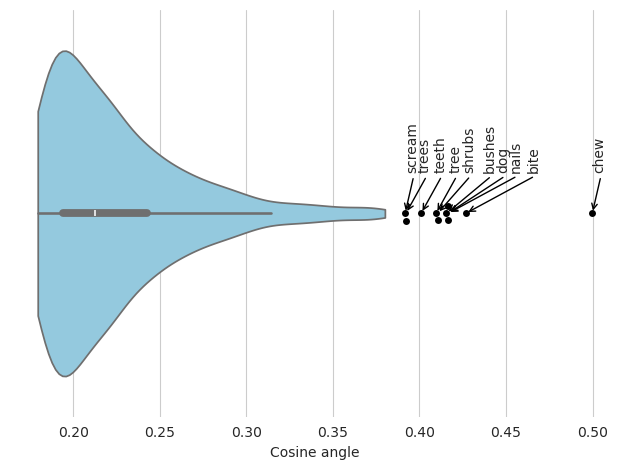

In [9]:
plot_similarity_distribution([r[1] for r in result], [r[0] for r in result])

Text(0, 0.5, 'Similarity to tree')

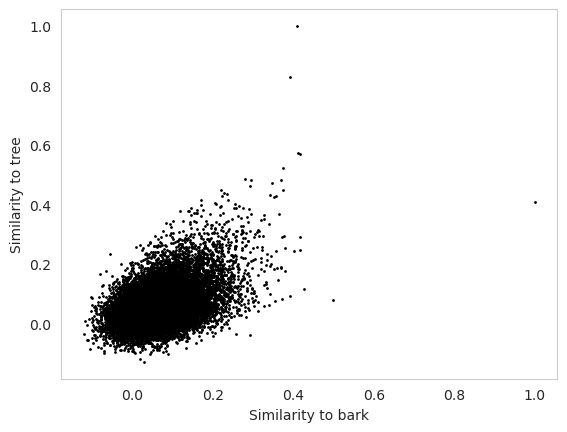

In [6]:

query_gene = "bark"
query_gene2 = "tree"

similarities_1 = similarities[words.index(query_gene)]
similarities_2 = similarities[words.index(query_gene2)]

plt.scatter(similarities_1, similarities_2, s=1,c='k')

plt.grid(False)
plt.xlabel(f"Similarity to {query_gene}")
plt.ylabel(f"Similarity to {query_gene2}")


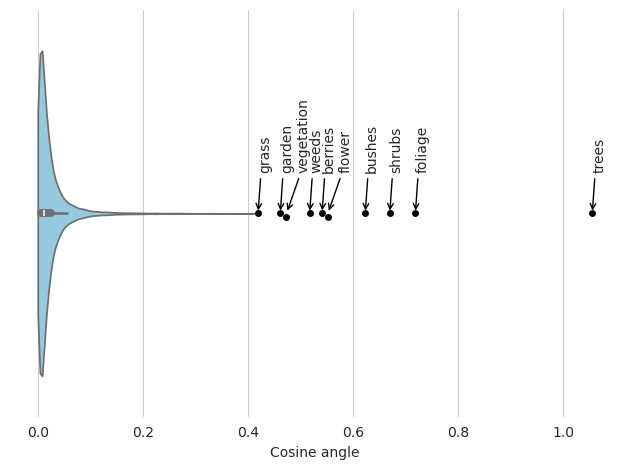

In [15]:
projections, top_words = joint_similarity(["bark","tree","leaf"], words, similarities)
plot_similarity_distribution(projections, top_words, 99.95, 0.02)

## Genes

In [9]:
embeddings = "geneformer"
truncate = 20000
use_cosine = True
top_k = 1000
path = "/home/benjami/gene_analogies/data/"

gene_descriptions = load_gene_descriptions()
if embeddings == "geneformer":
    M, words = load_geneformer_embeddings(path)
elif embeddings == "word2vec":
    M, words = load_word2vec_embeddings(path)
else:
    raise ValueError(f"Unknown embeddings: {embeddings}")

# Truncate embeddings and words if specified
if truncate > 0:
    M = M[:truncate]
    words = words[:truncate]

# Calculate similarities
similarities = calculate_similarities(M, use_cosine)

Calculating pairwise similarities...



Top 1000 genes most similar to ENSG00000132639 (synaptosome associated protein 25):

| Gene | Similarity | Description |
|------|------------|-------------|
| ENSG00000115556 | 0.830576 | phospholipase C delta 4 |
| ENSG00000156959 | 0.826847 | LHFPL tetraspan subfamily member 4 |
| ENSG00000184194 | 0.825036 | G protein-coupled receptor 173 |
| ENSG00000058453 | 0.825006 | ciliary rootlet coiled-coil, rootletin |
| ENSG00000122574 | 0.824405 | WAS/WASL interacting protein family member 3 |


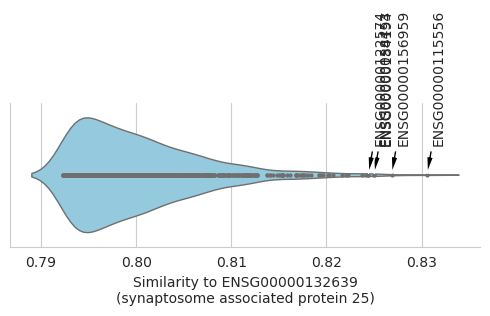

In [10]:
query_gene = "ENSG00000132639"

result = find_most_similar_genes(similarities, words, query_gene, top_k)

if result is None:
    print(f"Gene '{query_gene}' not found in the dataset.")
else:
    query_gene_description = gene_descriptions.get(query_gene, 'N/A').split(" [Source")[0]
    print(f"\nTop {len(result)} genes most similar to {query_gene} ({query_gene_description}):\n")
    
    print("| Gene | Similarity | Description |")
    print("|------|------------|-------------|")
    for gene, similarity in result[:5]:
        description = gene_descriptions.get(gene, 'N/A')
        description = description.split(" [Source")[0] if description is not None else 'N/A'
        print(f"| {gene} | {similarity:.6f} | {description} |")

sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))


sns.violinplot([r[1] for r in result], color='skyblue', orient='h', inner='point', linewidth=1)

# Annotate the top 5 points
for i, (index, value) in enumerate(result[:5]):
    plt.annotate(f'{index}', xy=(value, 0), xytext=(value+0.002, -0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=5),
                 horizontalalignment='right', verticalalignment='bottom',
                 rotation=90)



plt.xlabel(f"Similarity to {query_gene}\n({gene_descriptions.get(query_gene, 'N/A').split(' [Source')[0]})")
sns.despine()
plt.tight_layout()


The cosine of the angle with a vector and the plane spanned by two basis vectors is the _sum of squares_ of the cosine similarity between the vector and either of the two basis vectors. 

Text(0, 0.5, 'Sq. Similarity to ENSG00000106089\n(syntaxin 1A)')

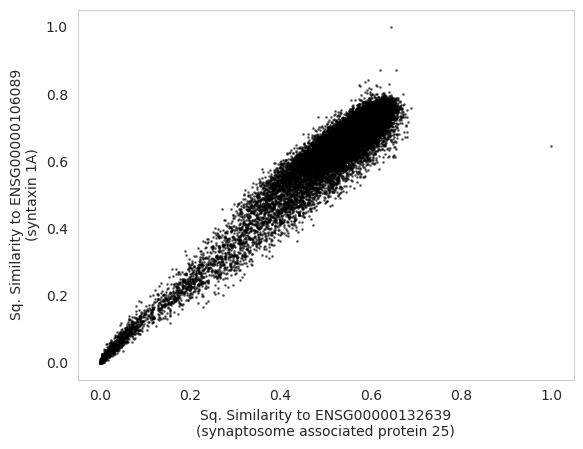

In [11]:

query_gene = "ENSG00000132639"
query_gene2 = "ENSG00000106089"

similarities_1 = similarities[words.index(query_gene)]
similarities_2 = similarities[words.index(query_gene2)]

plt.scatter(similarities_1**2, similarities_2**2, s=1,c='k', alpha=0.5)

plt.grid(False)
plt.xlabel(f"Sq. Similarity to {query_gene}\n({gene_descriptions.get(query_gene, 'N/A').split(' [Source')[0]})")
plt.ylabel(f"Sq. Similarity to {query_gene2}\n({gene_descriptions.get(query_gene2, 'N/A').split(' [Source')[0]})")


In [12]:
best_genes_idx = np.argsort(similarities_1**2 + similarities_2**2)[::-1]

print("|       Gene      | Description ")
print("|-----------------|   ------   ")
for i in best_genes_idx[2:15]:
    gene = words[i]
    description = gene_descriptions.get(gene, 'N/A')
    description = description.split(" [Source")[0] if description is not None else 'N/A'
    print(f"| {gene} | {description} |")

|       Gene      | Description 
|-----------------|   ------   
| ENSG00000168661 | zinc finger protein 30 |
| ENSG00000186166 | centrosomal AT-AC splicing factor |
| ENSG00000083838 | zinc finger protein 446 |
| ENSG00000197044 | zinc finger protein 441 |
| ENSG00000141519 | coiled-coil domain containing 40 |
| ENSG00000115556 | phospholipase C delta 4 |
| ENSG00000155592 | zinc finger with KRAB and SCAN domains 2 |
| ENSG00000102312 | porcupine O-acyltransferase |
| ENSG00000197050 | zinc finger protein 420 |
| ENSG00000149582 | transmembrane protein 25 |
| ENSG00000130224 | leucine rich repeats and calponin homology domain containing 2 |
| ENSG00000119401 | tripartite motif containing 32 |
| ENSG00000105708 | zinc finger protein 14 |


We can also find the genes that show the most different projections between the two basis vectors.

In [13]:
best_genes_idx = np.argsort(similarities_1 - similarities_2)[::-1]

print("|       Gene      | Description |")
print("|-----------------|-------------|")
for i in best_genes_idx[2:15]:
    gene = words[i]
    description = gene_descriptions.get(gene, 'N/A')
    description = description.split(" [Source")[0] if description is not None else 'N/A'
    print(f"| {gene} | {description} |")

|       Gene      | Description |
|-----------------|-------------|
| ENSG00000170477 | keratin 4 |
| ENSG00000205420 | keratin 6A |
| ENSG00000187821 | helt bHLH transcription factor |
| ENSG00000204612 | forkhead box B2 |
| ENSG00000067715 | synaptotagmin 1 |
| ENSG00000260970 | novel transcript |
| ENSG00000126233 | secreted LY6/PLAUR domain containing 1 |
| ENSG00000167656 | lymphocyte antigen 6 family member D |
| ENSG00000186847 | keratin 14 |
| ENSG00000125780 | transglutaminase 3 |
| ENSG00000169509 | cysteine rich C-terminal 1 |
| ENSG00000071203 | membrane spanning 4-domains A12 |
| ENSG00000204544 | mucin 21, cell surface associated |


In [14]:
best_genes_idx = np.argsort(similarities_2 - similarities_1)[::-1]

print("|       Gene      | Description |")
print("|-----------------|-------------|")
for i in best_genes_idx[2:15]:
    gene = words[i]
    description = gene_descriptions.get(gene, 'N/A')
    description = description.split(" [Source")[0] if description is not None else 'N/A'
    print(f"| {gene} | {description} |")

|       Gene      | Description |
|-----------------|-------------|
| ENSG00000182481 | karyopherin subunit alpha 2 |
| ENSG00000122644 | ADP ribosylation factor like GTPase 4A |
| ENSG00000071127 | WD repeat domain 1 |
| ENSG00000088992 | tescalcin |
| ENSG00000006634 | DBF4 zinc finger |
| ENSG00000185043 | calcium and integrin binding 1 |
| ENSG00000106346 | ubiquitin specific peptidase 42 |
| ENSG00000140990 | NADH:ubiquinone oxidoreductase subunit B10 |
| ENSG00000128272 | activating transcription factor 4 |
| ENSG00000184545 | dual specificity phosphatase 8 |
| ENSG00000173621 | leucine rich repeat and fibronectin type III domain containing 4 |
| ENSG00000134802 | solute carrier family 43 member 3 |
| ENSG00000204427 | abhydrolase domain containing 16A, phospholipase |


We can also find the genes that are most similar to a set of genes.

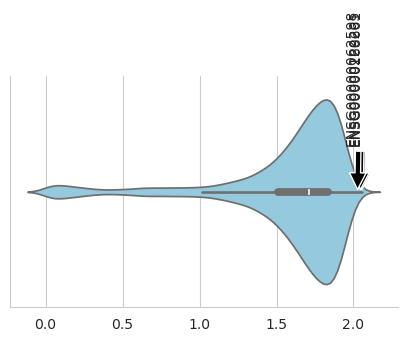

|       Gene      | Description | Score |
|-----------------|-------------| ----- |
| ENSG00000168661 | zinc finger protein 30 | 2.054385 |
| ENSG00000220205 | vesicle associated membrane protein 2 | 2.045412 |
| ENSG00000062598 | engulfment and cell motility 2 | 2.026154 |
| ENSG00000141258 | small G protein signaling modulator 2 | 2.025740 |
| ENSG00000196652 | zinc finger with KRAB and SCAN domains 5 | 2.023360 |
| ENSG00000083838 | zinc finger protein 446 | 2.021906 |
| ENSG00000101350 | kinesin family member 3B | 2.017807 |
| ENSG00000253251 | shieldin complex subunit 3 | 2.017493 |
| ENSG00000108352 | Rap guanine nucleotide exchange factor like 1 | 2.017186 |
| ENSG00000108840 | histone deacetylase 5 | 2.016700 |


In [15]:
projections, top_words = joint_similarity(["ENSG00000106089","ENSG00000132639","ENSG00000220205"], words, similarities)

plt.figure(figsize=(5, 3))

# Create the violin plot
sns.violinplot(projections, color='skyblue', orient='h')

# Annotate the top points
for i, (p, w) in enumerate(zip(projections, top_words)):
    plt.annotate(f'{w}', xy=(p, 0), xytext=(p+0.005, -0.2),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 horizontalalignment='right', verticalalignment='bottom',
                 rotation=90)
    if i >1: 
        break

sns.despine()

plt.show()

print("|       Gene      | Description | Score |")
print("|-----------------|-------------| ----- |")
for i in range(10):
    gene = top_words[i]
    description = gene_descriptions.get(gene, 'N/A')
    description = description.split(" [Source")[0] if description is not None else 'N/A'
    print(f"| {gene} | {description} | {projections[i]:.6f} |")

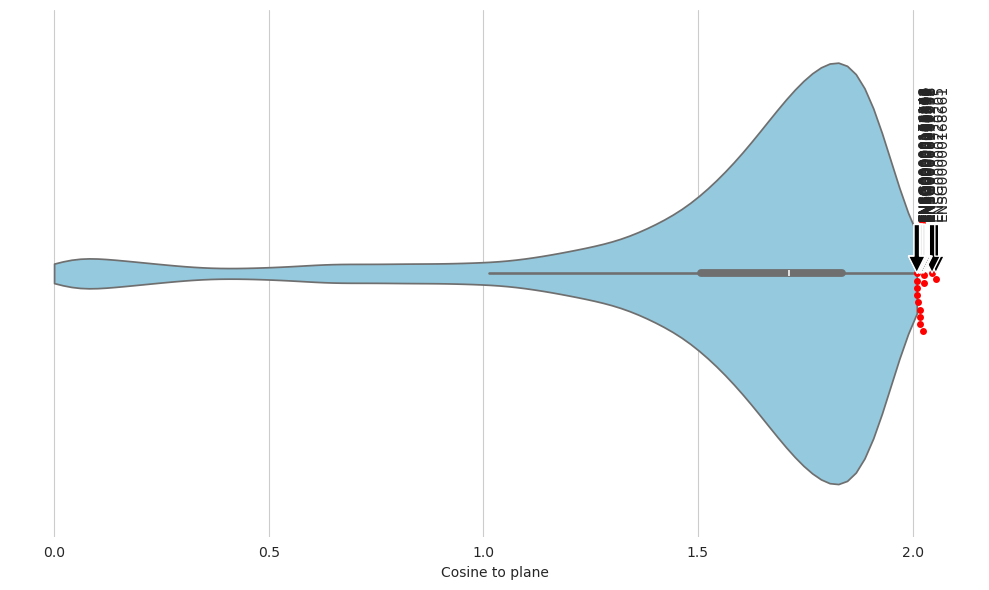

In [27]:


df = pd.DataFrame({'projections': projections, 'top_words': top_words})

# Calculate the 99th percentile
percentile_99 = np.percentile(projections, 99.9)

# Split the data
main_data = df[df['projections'] <= percentile_99]
outliers = df[df['projections'] > percentile_99]

# Set up the plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Create the custom violinplot
sns.violinplot(x='projections', data=main_data, color='skyblue', orient='h', cut=0, bw_adjust=1.)

# Add swarmplot for outliers
sns.swarmplot(x='projections', data=outliers, color='red', orient='h', size=5)

# Annotate the outlier points
for _, row in outliers.iterrows():
    plt.annotate(f'{row["top_words"]}', xy=(row['projections'], 0), xytext=(row['projections'], -0.1),
                 arrowprops=dict(facecolor='black', shrink=0.01),
                 horizontalalignment='left', verticalalignment='bottom',
                 rotation=90)

# Adjust layout and display
sns.despine(left=True, bottom=True)
plt.xlabel('Cosine to plane')
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.show()